# Generating heatmaps to show proximity of polygons

## Context
We are given a dataset of bedrock deposits. 
Each observation includes the type of rock and a shapely Polygon describing its position in space. 
We are interested in points where two types of bedrock are close together (eg., within 5-10 km). 
We want to visualize these points in a heatmap. 

## Task
Write a program that can generate a heat map based on the proximity of two different rock types, with an adjustable fall-off parameter. Generate a heatmap based on the proximity of serpenitite and granodiorite. Use python.

## Environment
I set up conda to support exploring, manipulating, and visualizing data with libraries like pandas, shapely, and matplotlib.

## Exploratory Data Analysis
I loaded the data into a GeoDataFrame and printed the head to look at the data. 
Two columns were relevant to the question: rock_type and geometry. 
For rock_type, I looked at a sample of the rock_type column and found that the rocks of interest had some specific labels:
- 'serpentinite' as 'serpentinite ultramafic rocks' or 'ultramafic rocks'
- 'granodiorite' as 'granodioritic intrusive rocks' 

For geometry, I mapped the Polygons to visualize them. I also projected colors onto the different types of rock deposits to get a sense of how they were distributed. 

## Solution
To produce the heatmap:
1. Find all the polygons of type A (serpentinite|ultramafic). 
2. Find all the polygons of type B (granodioritic). 
3. From each polygon (type A and B), make a new **buffered polygon**, by adding a buffer equal to 1/2 the proximity. 
4. Find all the **intersection polygons**, which are intersections of type A and type B buffered polygons. 
5. Find the centroids of all intersection polygons and plot them. 

Originally, I thought about using a different approach: 
1. Find all the points that belong to the outer edge of type A polygons.
2. Find all the points that belong to the outer edge of type B polygons.
3. Find all **proximity point sets**, which are all combinations of a type A point and a type B point with distance <= proximity. 
4. Find all **midpoints**, which are the midpoints between each proximity point, and plot them. 

But this heatmap would not "fall off smoothly"—every point that I plotted would be given equal weight, regardless of how close together the bedrock deposits were. So in the interest of time, I decided to use shapely instead. 

In [5]:
import copy
import geopandas as gpd
from shapely.geometry import Point

In [11]:
# Load and examine data

INPUT_FILE = "data/BedrockP.shp"
bd = gpd.read_file(INPUT_FILE)
bd.head(2)

,gid,upid,area_m2,strat_unit,era,period,strat_age,strat_name,gp_suite,fm_lithodm,...,terrane,basin,basin_age,project,src_url,src_ref_s,map_comp,edit_date,pub_org,geometry
0,33649.0,9c192ffb,4368828.0,uKPCvl,Mesozoic,Cretaceous,Upper Cretaceous,Powell Creek Formation - upper unit,None,Powell Creek Formation,...,Overlap,None,None,Chilcotin-Bonaparte,http://www.em.gov.bc.ca/Mining/Geoscience/Publ...,"Schiarizza et al., 1997, Chilcotin-Bonaparte, ...","Schiarizza, 2017, Chicotin-Bonaparte",2018-04-05,British Columbia Geological Survey,"POLYGON ((466212.803 5669781.240, 466385.735 5..."
1,26344.0,824df15e,34431394.0,lKGsv,Mesozoic,Cretaceous,Lower Cretaceous,Gambier Group,Gambier Group,None,...,Overlap,None,None,Mid-coast,http://www.em.gov.bc.ca/Mining/Geoscience/Publ...,"Bellefontaine et al., 1994, Mid-coast, BCGS, O...","Massey et al., 2005, BC",2018-04-05,British Columbia Geological Survey,"POLYGON ((541326.012 5529535.059, 541118.840 5..."


### Find all the polygons of type A (serpentinite|ultramafic) and type B (granodioritic).

In [16]:
typeARocksData = bd[bd['rock_type'].str.contains('serpentinite') | bd['rock_type'].str.contains('ultramafic')].loc[:, ['rock_type', 'geometry']]
typeARocksData = typeARocksData.loc[:, ['rock_type', 'geometry']]

typeBRocksData = bd[bd['rock_type'].str.contains('granodioritic')].loc[:, ['rock_type', 'geometry']]
typeBRocksData = typeBRocksData.loc[:, ['rock_type', 'geometry']]

### From each polygon, make a buffered polygon, by adding a buffer equal to 1/2 the proximity.

In [14]:
# I didn't have time to implement the buffer, so below, I simply check whether the bedrock deposits are touching.

### Find all the intersection polygons, which are intersections of type A and type B buffered polygons.

In [18]:
# We also take the centroid, which is the point of interest.

from shapely.geometry import MultiPoint

dfA = typeARocksData.copy()
dfA['centroids'] = typeARocksData.apply(
    lambda a: 
    MultiPoint([a.iloc[1].intersection(b[1]).centroid for i, b in typeBRocksData.iterrows() if a.iloc[1].intersects(b[1])]),
    axis=1)

dfA.head()

,rock_type,geometry,centroids
17,ultramafic rocks,"POLYGON ((550887.442 5638245.333, 550753.877 5...",()
24,serpentinite ultramafic rocks,"POLYGON ((531424.135 5613962.183, 531692.767 5...",(POINT (532347.1530945306 5611658.563644603))
39,serpentinite ultramafic rocks,"POLYGON ((530406.930 5614886.454, 530408.769 5...","(POINT (550816.6406047641 5586400.526095815), ..."
50,ultramafic rocks,"POLYGON ((544869.648 5596786.572, 544066.961 5...","(POINT (542346.2232715214 5599021.575625905), ..."
60,serpentinite ultramafic rocks,"POLYGON ((517670.470 5618847.114, 517516.725 5...",()


### Find the centroids of all intersection polygons and plot them.

<AxesSubplot:>

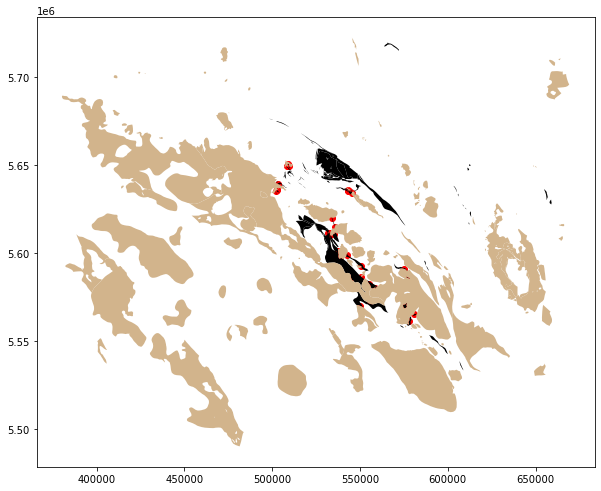

In [19]:
# I had planned to use geoplot for a heatmap that would fall away smoothly, but I had trouble installing it. 

type_a = dfA.copy()
type_b = typeBRocksData.copy()
centroids = dfA.copy().set_geometry("centroids")

ax = centroids.plot(color="red", figsize=(10, 10))
type_a.plot(ax=ax, color="black")
type_b.plot(ax=ax, color="tan")